# CSCI 4701: Python Code for Neural Network N-Gram Model

Highly based on Andrej Karpathy's [makemore](https://github.com/karpathy/makemore). See the [original video](https://www.youtube.com/watch?v=PaCmpygFfXo&list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ&index=3).

In [1]:
import requests

url = "https://raw.githubusercontent.com/karpathy/makemore/master/names.txt"
response = requests.get(url)
data = response.text
words = data.splitlines()

In [2]:
print('Length:', len(words))
print(words[:5] )

Length: 32033
['emma', 'olivia', 'ava', 'isabella', 'sophia']


This data provides information about names. For example, by having five examples `['emma', 'olivia', 'ava', 'isabella', 'sophia']` we may conclude that the probability of `'a'` being the last letter is `1.0` after which the word will certainly end, or that the letter `'o'` is more likely to be at the beginning of the name. Our goal will be to to predict the most probable next character. A common technique is to take track of bigrams of characters (there can be N-grams of words, etc., which have both advantages and disadvantages).

## Bigram Model

In [3]:
def get_bigrams(n):
  bigrams = {}
  for w in words[:n]:
    w = ['<START>'] + list(w) + ['<END>']
    for ch1, ch2 in zip(w, w[1:]):
      b = (ch1, ch2)
      bigrams[b] = bigrams.get(b, 0) + 1
  return bigrams

Change `n` up to 5 and take note of the bigram counts.

In [4]:
get_bigrams(n=2)

{('<START>', 'e'): 1,
 ('e', 'm'): 1,
 ('m', 'm'): 1,
 ('m', 'a'): 1,
 ('a', '<END>'): 2,
 ('<START>', 'o'): 1,
 ('o', 'l'): 1,
 ('l', 'i'): 1,
 ('i', 'v'): 1,
 ('v', 'i'): 1,
 ('i', 'a'): 1}

In [5]:
from collections import Counter

bigrams = get_bigrams(len(words))
Counter(bigrams).most_common()

[(('n', '<END>'), 6763),
 (('a', '<END>'), 6640),
 (('a', 'n'), 5438),
 (('<START>', 'a'), 4410),
 (('e', '<END>'), 3983),
 (('a', 'r'), 3264),
 (('e', 'l'), 3248),
 (('r', 'i'), 3033),
 (('n', 'a'), 2977),
 (('<START>', 'k'), 2963),
 (('l', 'e'), 2921),
 (('e', 'n'), 2675),
 (('l', 'a'), 2623),
 (('m', 'a'), 2590),
 (('<START>', 'm'), 2538),
 (('a', 'l'), 2528),
 (('i', '<END>'), 2489),
 (('l', 'i'), 2480),
 (('i', 'a'), 2445),
 (('<START>', 'j'), 2422),
 (('o', 'n'), 2411),
 (('h', '<END>'), 2409),
 (('r', 'a'), 2356),
 (('a', 'h'), 2332),
 (('h', 'a'), 2244),
 (('y', 'a'), 2143),
 (('i', 'n'), 2126),
 (('<START>', 's'), 2055),
 (('a', 'y'), 2050),
 (('y', '<END>'), 2007),
 (('e', 'r'), 1958),
 (('n', 'n'), 1906),
 (('y', 'n'), 1826),
 (('k', 'a'), 1731),
 (('n', 'i'), 1725),
 (('r', 'e'), 1697),
 (('<START>', 'd'), 1690),
 (('i', 'e'), 1653),
 (('a', 'i'), 1650),
 (('<START>', 'r'), 1639),
 (('a', 'm'), 1634),
 (('l', 'y'), 1588),
 (('<START>', 'l'), 1572),
 (('<START>', 'c'), 1542)

We will store bigrams in a `PyTorch` tensor instead of a dictionary. Each character will be mapped to an id.

In [7]:
import string

# character mapping from string to integer
chars = list(string.ascii_lowercase)
stoi = {ch: i for i, ch in enumerate(chars)}
stoi['<START>'] = 26
stoi['<END>'] = 27
stoi

{'a': 0,
 'b': 1,
 'c': 2,
 'd': 3,
 'e': 4,
 'f': 5,
 'g': 6,
 'h': 7,
 'i': 8,
 'j': 9,
 'k': 10,
 'l': 11,
 'm': 12,
 'n': 13,
 'o': 14,
 'p': 15,
 'q': 16,
 'r': 17,
 's': 18,
 't': 19,
 'u': 20,
 'v': 21,
 'w': 22,
 'x': 23,
 'y': 24,
 'z': 25,
 '<START>': 26,
 '<END>': 27}

In [8]:
import torch

SIZE = len(stoi)

def get_bigrams(n):
  bigrams = torch.zeros((SIZE, SIZE))
  for w in words[:n]:
    w = ['<START>'] + list(w) + ['<END>']
    for ch1, ch2 in zip(w, w[1:]):
      bigrams[stoi[ch1], stoi[ch2]] += 1
  return bigrams

In [9]:
bigrams = get_bigrams(len(words))

We can refer to bigrams by indices and slicing. Modify `i` and `j` and run the code to get a sense of the table.

In [10]:
itos = {ch: i for i, ch in stoi.items()} # reverse stoi

i, j = 0, 1
count = bigrams[i, j]
print(f'({itos[i]}, {itos[j]}): {count}')

(a, b): 541.0


**Exercise:** Find the probability of a character (e.g. `b`) being the first character (hint: it will follow `<START>`).

In [11]:
counts = bigrams[stoi['<START>']]
probs = counts / counts.sum()
probs[stoi['b']]

tensor(0.0408)

To generate some output we need to understand `torch.multinomial`. Let's have a simpler probability distribution for three classes (`0`, `1`, `2`). Our goal is to generate `n` samples according to the given probabilities. Setting `replacement=True` means the same class index can be picked multiple times. The higher a class' probability, the more often it is likely to appear in the samples. Rerun the cell below and notice how probabilities are related to the generated samples.

In [12]:
p = torch.rand(3)
p /= p.sum()
samples = torch.multinomial(p, num_samples=10, replacement=True)

print(p)
print(samples)

tensor([0.5375, 0.1891, 0.2735])
tensor([0, 0, 0, 2, 0, 1, 0, 0, 1, 0])


Once we understand the logic of `torch.multinomial`, we will randomly pick a next character based on our probability distribution. The higher is the frequency of the bigram, the more likely is that the random sampler will return us that character.

In [13]:
next_char = torch.multinomial(probs, num_samples=1, replacement=True)
next_char, itos[next_char.item()]

(tensor([17]), 'r')

We will start with bigrams of `<START>`. Once we randomly generate the next character based on its probability distribution, we will start looking for bigrams starting with that generated character. This process will continue until we our sampling returns `<END>`.

 We will work with the probability matrix from now on, instead of the frequency matrix. Below, `dim=1` ensures that we sum along the row of the matrix, when `keepdim=True` keeps the extra dimension. Refer to the `PyTorch` documentation and test out different parameters.

In [14]:
probs = bigrams/bigrams.sum(dim=1, keepdim=True)
probs.shape

torch.Size([28, 28])

In [15]:
def sample_names(n=10):
  names = ''
  for i in range(n):
    id = stoi['<START>']
    while id != stoi['<END>']:
      p = probs[id]
      next_char = torch.multinomial(p, 1, replacement=True)
      id = next_char.item()
      names += itos[id]
  return names.replace("<END>", "\n")

In [21]:
print(sample_names())

tarios
caly
kelaherthrwa
dyaronn
zenel
brid
c
sh
ve
minica



## Average Negative Log-Likelihood

We can evaluate our model and determine the loss function with [likelihood](https://en.wikipedia.org/wiki/Likelihood_function). Note that our prediction probabilities are generated by simply counting bigram frequencies.

In [22]:
n = 1
for w in words[:n]:
  w = ['<START>'] + list(w) + ['<END>']
  for ch1, ch2 in zip(w, w[1:]):
    p = probs[stoi[ch1], stoi[ch2]]
    print(f'{ch1, ch2}: {p.item():.4f}')

('<START>', 'e'): 0.0478
('e', 'm'): 0.0377
('m', 'm'): 0.0253
('m', 'a'): 0.3899
('a', '<END>'): 0.1960


The logic of bigram model is that the probability of rare characters coming together in names (e.g. `xy`) will be much smaller than the more common cases (e.g. `na`). A better training corpus captures more realistic character transitions and assigns higher probabilities to frequently seen patterns.

Since the model assumes that each character depends only on the previous one (Markov assumption), the joint probability of a sequence is the product of all conditional probabilities:

$P(c_1, c_2, \ldots, c_n) = P(c_1) \cdot P(c_2 \mid c_1) \cdot P(c_3 \mid c_2) \cdots P(c_n \mid c_{n-1})$

**Likelihood** estimates this quality for our model by multiplying all prediction probabilities. Higher is the joint probability, the better is model's prediction quality. However, direct multiplication may have the following issue:

In [24]:
n = 5
for word in words[:n]:
  likelihood = 1.0
  w = ['<START>'] + list(word) + ['<END>']
  for ch1, ch2 in zip(w, w[1:]):
    p = probs[stoi[ch1], stoi[ch2]]
    likelihood *= p
  print(f'Model predicts {word} is {likelihood:.9f} likely')

Model predicts emma is 0.000003478 likely
Model predicts olivia is 0.000000025 likely
Model predicts ava is 0.000165674 likely
Model predicts isabella is 0.000000000 likely
Model predicts sophia is 0.000000026 likely


**Question:** How to fix the issue above?

As can be seen, the result of chained multiplication is a very small number (somewhat resembling vanishing gradient problem). To resolve this issue, individual probabilities between `0` and `1` are mapped to a `log` function domain (-$\infty$, 0]. Logarithm function is monotonic (preserves order): maximum probability is mapped to `0`, smaller probabilities are mapped to bigger negative values.

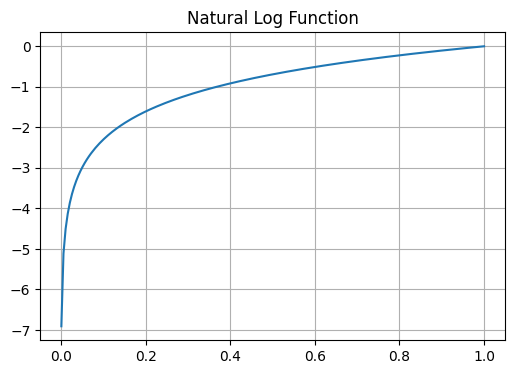

In [25]:
import numpy as np
import matplotlib.pyplot as plt

p = np.linspace(0.001, 1, 200)
log_p = np.log(p)

plt.figure(figsize=(6, 4))
plt.plot(p, log_p)
plt.title("Natural Log Function")
plt.grid(True)

In [26]:
n = 1
for w in words[:n]:
  w = ['<START>'] + list(w) + ['<END>']
  for ch1, ch2 in zip(w, w[1:]):
    p = probs[stoi[ch1], stoi[ch2]]
    log_p = torch.log(p)
    print(f'{ch1, ch2}: {p.item():.4f} | {log_p.item():.4f}')

('<START>', 'e'): 0.0478 | -3.0408
('e', 'm'): 0.0377 | -3.2793
('m', 'm'): 0.0253 | -3.6772
('m', 'a'): 0.3899 | -0.9418
('a', '<END>'): 0.1960 | -1.6299


**Log-likelihood** also has an advantage of making calculations and hence optimization (calculation of gradients) faster due to the product rule:

$\log P(c_1, c_2, \ldots, c_n) = \log P(c_1) + \log P(c_2 \mid c_1) + \log P(c_3 \mid c_2) + \cdots + \log P(c_n \mid c_{n-1})$

In [27]:
n = 5
for word in words[:n]:
  log_likelihood = 0.0
  w = ['<START>'] + list(word) + ['<END>']
  for ch1, ch2 in zip(w, w[1:]):
    p = probs[stoi[ch1], stoi[ch2]]
    log_p = torch.log(p)
    log_likelihood += log_p
  print(f'Model predicts {word} is {log_likelihood} likely')

Model predicts emma is -12.568990707397461 likely
Model predicts olivia is -17.511159896850586 likely
Model predicts ava is -8.705486297607422 likely
Model predicts isabella is -21.5141544342041 likely
Model predicts sophia is -17.468196868896484 likely


As optimization algorithms usually strive for minimizing the loss, it makes sense to invert the negative values of the log-likelihood to be positive. We can generate a single loss value by **averaging negative log-likelihoods** across all the samples.

In [30]:
log_likelihood = 0.0
for word in words:
  w = ['<START>'] + list(word) + ['<END>']
  for ch1, ch2 in zip(w, w[1:]):
    p = probs[stoi[ch1], stoi[ch2]]
    log_p = torch.log(p)
    log_likelihood += log_p
loss = -log_likelihood / len(words)
print(f'Loss: {loss}')

Loss: 17.478591918945312


As we know, logarithmic function is undefined at `0`, which we need to take into consideration. Consider the case when a character combination has never occured in our training data.

In [31]:
for word in ['jq']:
  log_likelihood = 0.0
  w = ['<START>'] + list(word) + ['<END>']
  for ch1, ch2 in zip(w, w[1:]):
    p = probs[stoi[ch1], stoi[ch2]]
    log_p = torch.log(p)
    log_likelihood += log_p
  print(f'Model predicts {word} is {log_likelihood} likely')

Model predicts jq is -inf likely


In case any character sequence in string will return infinite likelihood, it will lead to infinite loss as well, which is undesirable.

**Question:** How to avoid infinite loss?

**Model-smoothing** is a simple technique, which aims to assign a minimal non-zero probability to cases leading to infinite likelihood. Run the next cell and replicate the experiments above to see the outcome.

In [32]:
bigrams = bigrams + 1  # model smoothing avoids zero probabilities
probs = bigrams/bigrams.sum(dim=1, keepdim=True)

## Neural Network Bigram Model

Our frequency-based bigram model didn't perform well due its simplicity. We will now build a neural network-based bigram model with the aim of increasing individual bigram prediction probabilities (recall that likelihood was calculated by multiplying conditional probabilities). Instead of counting bigrams in our training set, we will learn parameters leading to reduced loss. We will now rewrite our `get_bigrams()` function to suit the training of neural network model, where the label of each character will be the next character.

In [33]:
def get_bigrams(n):
  X, Y = [], []
  for w in words[:n]:
    w = ['<START>'] + list(w) + ['<END>']
    for ch1, ch2 in zip(w, w[1:]):
      X.append(stoi[ch1])
      Y.append(stoi[ch2])
  return torch.tensor(X), torch.tensor(Y)

In [34]:
X, Y = get_bigrams(1)
X, Y

(tensor([26,  4, 12, 12,  0]), tensor([ 4, 12, 12,  0, 27]))

In [35]:
[itos[x.item()] for x in X], [itos[y.item()] for y in Y]

(['<START>', 'e', 'm', 'm', 'a'], ['e', 'm', 'm', 'a', '<END>'])

We will one-hot encode our data with the `torch.nn.functional` module function, in order to not inject unnecessary numerical pattern to our data.

In [38]:
import torch.nn.functional as F

X_train = F.one_hot(X, num_classes=SIZE).float()
y_train = F.one_hot(Y, num_classes=SIZE).float()

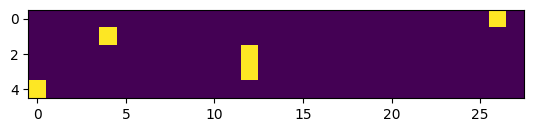

In [39]:
plt.imshow(X_train);

We will now generate weights for each character and find their linear transformation.

In [41]:
W = torch.randn((SIZE, 1))
X_train @ W

tensor([[ 0.5013],
        [-0.8258],
        [ 1.0634],
        [ 1.0634],
        [ 0.9002]])

For each input character, our goal is to predict not a single probability, but probabilities for all possible output characters. Hence, we will update our weight matrix to correspond to both input and output. We will set `requires_grad=True` for future gradient calculation.

In [42]:
W = torch.randn((SIZE, SIZE), requires_grad=True)
(X_train @ W).shape

torch.Size([5, 28])

Note that `torch.randn()` function is generating weight values corresponding to Guassian distribution. Our goal is to map these values to all be positive, so that we can interpret the ouput as probabilities later on. The idea is similar to `log()` function previously. Here, the output values lower than zero will be mapped to be below `1` approaching `0`, when positive values will grow towards infinity.

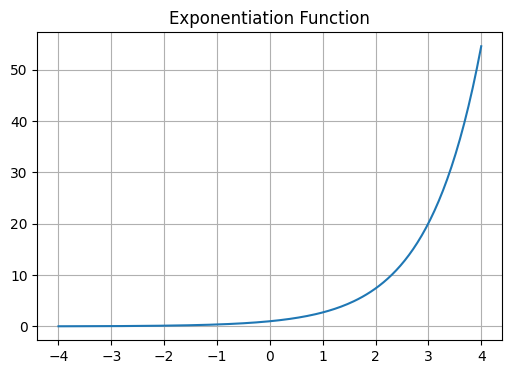

In [43]:
x = np.linspace(-4, 4, 200)
exp_x = np.exp(x)

plt.figure(figsize=(6, 4))
plt.plot(x, exp_x)
plt.title("Exponentiation Function")
plt.grid(True)

We call the raw scores we obtain after a linear transformation **logits** (log-counts). These values are real numbers, not constrained to be positive or normalized. To interpret them as prediction probabilities, we apply the exponential function to map them to the positive domain. The output of exponentiation can be interpreted as unnormalized character frequencies or relative likelihoods. When we normalize these exponentials (i.e. divide by their total sum), we obtain values that sum to `1.0`, forming a proper probability distribution. This is exactly what we want. Note that all these functions are differentiable and applying exponentiation and normalization is exactly what **softmax** function does:

$\text{softmax}(z_i) = \frac{\exp(z_i)}{\sum_{j=1}^{K} \exp(z_j)}$


In [44]:
logits = X_train @ W

# softmax
counts = torch.exp(logits)
probs = counts / counts.sum(dim=1, keepdim=True)

probs[0], probs[0].sum()

(tensor([0.0471, 0.0249, 0.0381, 0.0411, 0.0384, 0.0678, 0.0478, 0.0210, 0.0155,
         0.0191, 0.0920, 0.0500, 0.0138, 0.0090, 0.0042, 0.0120, 0.1256, 0.0500,
         0.0855, 0.0199, 0.0043, 0.0082, 0.0215, 0.0744, 0.0232, 0.0054, 0.0234,
         0.0168], grad_fn=<SelectBackward0>),
 tensor(1.0000, grad_fn=<SumBackward0>))

**Exercise:** Calculate the average negative log-likelihood (loss) of the model.

In [45]:
pred_probs = probs[torch.arange(len(Y)), Y]
loss = -pred_probs.log().mean()
loss

tensor(3.5038, grad_fn=<NegBackward0>)

We know how to call backward pass and optimize our model from previous lectures. We will combine all the steps, train our model on the whole dataset, and backpropagate through our network.

In [46]:
X, Y = get_bigrams(len(words))

X_train = F.one_hot(X, num_classes=SIZE).float()
y_train = F.one_hot(Y, num_classes=SIZE).float()

W = torch.randn((SIZE, SIZE), requires_grad=True)

In [47]:
num_epochs = 100
learning_rate = 1
lambda_ = 0.01

for epoch in range(num_epochs):
  # forward pass
  logits = X_train @ W
  counts = torch.exp(logits)
  probs = counts / counts.sum(dim=1, keepdim=True)
  pred_probs = probs[torch.arange(len(Y)), Y]

  l2 = (W**2).sum() # regularization
  loss = -pred_probs.log().mean() + lambda_ * l2.sum()

  # backward pass
  W.grad = None
  loss.backward()

  # optimization
  W.data -= learning_rate * W.grad

  if (epoch + 1) % 10 == 0:
    print(f'{epoch+1}/{num_epochs}, loss: {loss}')

10/100, loss: 9.035313606262207
20/100, loss: 7.005525588989258
30/100, loss: 5.685214042663574
40/100, loss: 4.8257904052734375
50/100, loss: 4.2659807205200195
60/100, loss: 3.901088237762451
70/100, loss: 3.6630942821502686
80/100, loss: 3.5077712535858154
90/100, loss: 3.406341552734375
100/100, loss: 3.3400678634643555


## Neural Network N-gram Model

Follows the implementation of Yoshua Bengio, Réjean Ducharme, Pascal Vincent, and Christian Janvin: [A neural probabilistic language model](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf), based on Andrej Karpathy's [building makemore: part 2](https://www.youtube.com/watch?v=TCH_1BHY58I&list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ&index=4).

We will modify the `get_bigrams()` function to include custom `block_size`, which simply implies `N-1` of `N-gram` (bigram has the block size of `1`).

In [48]:
def get_ngrams(end, start=0, block_size=3):
  X, Y = [], []
  for w in words[start:end]:
    context = ['<START>'] * block_size
    for ch in list(w) + ['<END>']:
      X.append([stoi[c] for c in context])
      Y.append(stoi[ch])
      context = context[1:] + [ch]
  return torch.tensor(X), torch.tensor(Y)

In [49]:
X, Y = get_ngrams(1, block_size=3) # try different block sizes

In [50]:
for x, y in zip(X, Y):
  context = [itos[i.item()] for i in x]
  target = itos[y.item()]
  print(f"{context}: {target}")

['<START>', '<START>', '<START>']: e
['<START>', '<START>', 'e']: m
['<START>', 'e', 'm']: m
['e', 'm', 'm']: a
['m', 'm', 'a']: <END>


It is managable to convert `28` character indices by one hot encoding them to suit a neural network. However, this approach becomes innefficient when the vocabulary size increases. What if we have `10,000` words and our goal is to predict the next word? We would have to create large vectors with lots of zeros, not only wasting resources, but also losing similarity information among tokens (dot product of any two vectors will always be `0` due to orthogonality).

A different approach is to get some smaller dimensional embedding of an index. Initially, these embeddings (parameters) are random, but over the course of training, model updates them to reflect the actual usage of the words in a context. When vectors of two different characters are learned to be close to each other, then we can conclude that, in our data, these characters were in a similar context. If two characters often show up in the same positions relative to surrounding characters, their embeddings get pulled toward each other. Consider the simple case below:

```python
context1 = ['b', 'a', 'd', 'a']
context2 = ['m', 'a', 'd', 'a']
target = 'm'
```
If the training data consists of these contexts, then, in order to predict `m` for both contexts, their learned embeddings should be similar in value.

For our case, `2` dimensional embeddings will be enough. For small datasets, having high embedding dimensionality may cause overfitting. When dataset is bigger, increasing dimensions helps to learn more nuanced relationships in the data, albeit at a higher computational cost.

In [51]:
X

tensor([[26, 26, 26],
        [26, 26,  4],
        [26,  4, 12],
        [ 4, 12, 12],
        [12, 12,  0]])

In [52]:
C = torch.randn((SIZE, 2))
emb = C[X]
emb

tensor([[[-0.6723,  0.3140],
         [-0.6723,  0.3140],
         [-0.6723,  0.3140]],

        [[-0.6723,  0.3140],
         [-0.6723,  0.3140],
         [-1.4631, -1.0324]],

        [[-0.6723,  0.3140],
         [-1.4631, -1.0324],
         [ 0.6817,  1.5840]],

        [[-1.4631, -1.0324],
         [ 0.6817,  1.5840],
         [ 0.6817,  1.5840]],

        [[ 0.6817,  1.5840],
         [ 0.6817,  1.5840],
         [-0.8068,  0.7403]]])

Now we will initilaize weights and biases by considering correct shape. In order to be able to use matrix multiplication, we will have to flatten embeddings as well.

In [53]:
emb.shape

torch.Size([5, 3, 2])

**Question:** What do embedding dimensions correspond to?

**Exercise:** Pass embeddings through a single neuron.

In [57]:
layer_size = 100
in_features = emb.shape[1] * emb.shape[2]

W1 = torch.randn((in_features, layer_size))
b1 = torch.randn(layer_size)

out = emb.view(-1, in_features) @ W1 + b1
act = torch.tanh(out)

W1.shape, b1.shape, out.shape

(torch.Size([6, 100]), torch.Size([100]), torch.Size([5, 100]))

In [58]:
emb.view(-1, in_features)

tensor([[-0.6723,  0.3140, -0.6723,  0.3140, -0.6723,  0.3140],
        [-0.6723,  0.3140, -0.6723,  0.3140, -1.4631, -1.0324],
        [-0.6723,  0.3140, -1.4631, -1.0324,  0.6817,  1.5840],
        [-1.4631, -1.0324,  0.6817,  1.5840,  0.6817,  1.5840],
        [ 0.6817,  1.5840,  0.6817,  1.5840, -0.8068,  0.7403]])

**Exercise:** Create the next (final) layer.

In [59]:
W2 = torch.randn((layer_size, SIZE))
b2 = torch.randn(SIZE)

logits = act @ W2 + b2
logits.shape

torch.Size([5, 28])

**Exercise:** Calculate loss.

In [60]:
counts = logits.exp()
prob = counts / counts.sum(dim=1, keepdim=True)
prob.shape

torch.Size([5, 28])

In [65]:
loss = -prob[torch.arange(prob.shape[0]), Y].log().mean()
loss

tensor(16.2439)

Average negative log-likelihood loss can be calculated with built-in `PyTorch` functions as well. **Cross-entropy** is simply `Softmax + Negative Log-Likelihood`.

In [66]:
# loss = F.nll_loss(torch.log(prob), Y)
loss = F.cross_entropy(logits, Y)
loss

tensor(16.2439)

**Exercise:** Let's combine everything together and train on whole data.

In [96]:
X, Y = get_ngrams(len(words))

In [97]:
C = torch.randn((SIZE, 2), requires_grad=True)
emb = C[X]

layer_size = 100
in_features = emb.shape[1] * emb.shape[2]

W1 = torch.randn((in_features, layer_size), requires_grad=True)
b1 = torch.randn(layer_size, requires_grad=True)

W2 = torch.randn((layer_size, SIZE), requires_grad=True)
b2 = torch.randn(SIZE, requires_grad=True)

params = [C, W1, W2, b1, b2]

In [100]:
def train(X, Y, params, num_epochs=10, learning_rate=0.01):
  C, W1, W2, b1, b2 = params
  for epoch in range(num_epochs):
    # forward pass
    emb = C[X]
    in_features = emb.shape[1] * emb.shape[2]
    out = emb.view(-1, in_features) @ W1 + b1
    act = torch.tanh(out)
    logits = act @ W2 + b2
    loss = F.cross_entropy(logits, Y)
    print(f'Epoch: {epoch+1}/{num_epochs}, Loss: {loss}')
    # backward pass
    for p in params:
      p.grad = None
    loss.backward()
    # optimization
    for p in params:
      p.data -= learning_rate * p.grad

In [101]:
train(X, Y, params)

Epoch: 1/10, Loss: 14.651238441467285
Epoch: 2/10, Loss: 14.548416137695312
Epoch: 3/10, Loss: 14.447701454162598
Epoch: 4/10, Loss: 14.349052429199219
Epoch: 5/10, Loss: 14.252448081970215
Epoch: 6/10, Loss: 14.157876968383789
Epoch: 7/10, Loss: 14.065322875976562
Epoch: 8/10, Loss: 13.974783897399902
Epoch: 9/10, Loss: 13.886248588562012
Epoch: 10/10, Loss: 13.799703598022461


### Training on Mini-Batches

**Exercise:** Notice how slow it is to train on the whole data. Find out why. Can you also train on mini-batches? See the hint below:

In [102]:
batch_size = 4
idx = torch.randint(0, X.shape[0], (batch_size,))
idx, X[idx]

(tensor([114762,  40173,  66663,  87063]),
 tensor([[ 7, 11,  4],
         [18,  4, 24],
         [ 0, 13,  4],
         [12,  8, 11]]))

In [103]:
def run(X, Y, params, num_epochs, lr=0.1, batch_size=None):
  C, W1, W2, b1, b2 = params

  for epoch in range(1, num_epochs+1):
    if batch_size:
      idx = torch.randint(0, X.size(0), (batch_size,))
      batch_X, batch_Y = X[idx], Y[idx]
    else:
      batch_X, batch_Y = X, Y

    emb = C[batch_X]
    in_features = emb.shape[1] * emb.shape[2]
    out = emb.view(-1, in_features) @ W1 + b1
    act = torch.tanh(out)
    logits = act @ W2 + b2
    loss = F.cross_entropy(logits, batch_Y)

    if epoch % (100 if batch_size else 1) == 0:
      print(f'Epoch {epoch}, Loss {loss.item()}')

    for p in params:
      p.grad = None
    loss.backward()

    with torch.no_grad():
      for p in params:
        p.data -= lr * p.grad

In [104]:
run(X, Y, params, num_epochs=10, batch_size=None)

Epoch 1, Loss 13.715128898620605
Epoch 2, Loss 12.94245719909668
Epoch 3, Loss 12.326409339904785
Epoch 4, Loss 11.779574394226074
Epoch 5, Loss 11.269842147827148
Epoch 6, Loss 10.805395126342773
Epoch 7, Loss 10.449189186096191
Epoch 8, Loss 10.27437686920166
Epoch 9, Loss 9.558894157409668
Epoch 10, Loss 9.190631866455078


In [105]:
run(X, Y, params, num_epochs=1000, batch_size=64)

Epoch 100, Loss 2.8726632595062256
Epoch 200, Loss 2.904355525970459
Epoch 300, Loss 3.114861488342285
Epoch 400, Loss 2.7828195095062256
Epoch 500, Loss 2.580034017562866
Epoch 600, Loss 2.742938995361328
Epoch 700, Loss 2.582310676574707
Epoch 800, Loss 2.6041131019592285
Epoch 900, Loss 2.6011006832122803
Epoch 1000, Loss 2.5459964275360107
